# Aim : To find the rate of spread of covid under different conditions

In [1]:
# Common variables

N = 1       # Number of simulations for a given set of conditions
P = 1000    # Number of people in each simulation
L = 10      # Size of the square box
r = 0.1     # Radius of infection
p = 0.1     # Probability of getting infected
T = 10     # Number of time steps in a day
D = 10      # Number of days the person stays infected


# Baseline :

P people are standing inside a L x L square. They are moving in random manner. If they get close to an infected person then they have a probability p to get infected. New infections are activated at the end of the day. Time spent near the person is not related to the probabiity of getting infected. infections are detected once the total number of infected reaches one percent of the population (though there are no counter measures at the moment). The total population is divided into 3 parts:

S : Susceptible

I : Infected

R : Removed (Dead or cured/immune from now on)

Simulations ends when there are no more infected. An infected person becomes cured/dead in D days. Since they play no role in this simulation once they are removed, they act like they are cured.

In [2]:
import random
import math
import time
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
# Baseline support functions and classes

class Person:
    
    # Contains all the information needed to track individually
    
    def __init__(self, pos):
        
        self.pos = pos
        self.status = 'S'
        self.proximity_to_infected = False
        self.days_infected = 0


class Population:
    
    # Contains the population and the related functions
    
    def __init__(self, P, L, r, p, T):
        
        # Initialize the population at random locations
        
        self.P = P
        self.L = L
        self.r = r
        self.p = p
        self.T = T
        self.D = D
        self.Pop = [self.generate_person() for i in range(self.P)]
        self.n_S = self.P
        self.n_I = 0
        self.n_R = 0

    def generate_person(self):
        
        # Initialize each person at a random location
        
        pos = [random.random()*self.L, random.random()*self.L]
        return Person(pos)
    
    def show_pos(self):
        
        # Displays the position of each person and the their status using colors
        
        clear_output(wait = True)
        plt.figure(figsize=(8,8))
        
        for S,color in zip(['S', 'I', 'R'], ['cyan', 'orange', 'black']):

            pos_x = [-1]*self.P
            pos_y = [-1]*self.P

            for i in range(self.P):

                if self.Pop[i].status == S:
                    
                    pos_x[i], pos_y[i] = self.Pop[i].pos[0], self.Pop[i].pos[1] 
                    
            pos_x = [i for i in pos_x if i != -1]
            pos_y = [i for i in pos_y if i != -1]

            plt.scatter(pos_x, pos_y, s = 6, c = color)
        
        plt.show()
        
    
    def start_infection(self):
        
        # Starts the infection with one person
        
        self.Pop[0].status = 'I'
        self.n_S -= 1
        self.n_I += 1
        self.Pop[0].days_infected = 1
        
    def move_person(self, i, v):
        
        # Moves a person in each time step of the day in a random direction
        # Ensures that the person stays inside the boundary
    
        theta = random.random()*math.pi*2 
        current_pos = self.Pop[i].pos
        self.Pop[i].pos = [current_pos[0] + v*math.cos(theta), current_pos[1] + v*math.sin(theta)]
        if self.Pop[i].pos[0] < 0:
            self.Pop[i].pos[0] = 0
        elif self.Pop[i].pos[0] > self.L:
            self.Pop[i].pos[0] = self.L
            
        if self.Pop[i].pos[1] < 0:
            self.Pop[i].pos[1] = 0
        elif self.Pop[i].pos[1] > self.L:
            self.Pop[i].pos[1] = self.L
            
            
    def infection_distance(self):
        
        # Checks if any person has come into the infection range of an infected person
        
        infected_pos = []
        
        for i in range(self.P):
            
            if self.Pop[i].status == 'I':
                
                infected_pos.append(self.Pop[i].pos)
                
        for i in range(self.P):
            
            if self.Pop[i].status != 'S':
                
                continue
                
            if self.Pop[i].proximity_to_infected:
                
                continue
            
            x,y = self.Pop[i].pos[0], self.Pop[i].pos[1]
            
            for i_pos in infected_pos:
                
                dis = math.sqrt((i_pos[0] - x)**2 + (i_pos[1] - y)**2)
                
                if dis < self.r:
                    
                    self.Pop[i].proximity_to_infected = True        
    
    
    def Simulate_day(self, v):
        
        # Running the simulation for a day
        
        for _ in range(self.T):
            
            for i in range(self.P):
                
                self.move_person(i, v)
            
            self.infection_distance()
    
    
    def set_infections(self):
        
        # Changes the infection status at the end of the day
        
        for i in range(self.P):
            
            if self.Pop[i].status == 'S' and self.Pop[i].proximity_to_infected:
                
                if random.random() <= self.p:
                    
                    self.Pop[i].status = 'I'
                    self.Pop[i].proximity_to_infected = 1
                    self.n_I += 1
                    self.n_S -= 1
                
                else:
                    
                    self.Pop[i].proximity_to_infected = False
                
            elif self.Pop[i].status == 'I':
                
                if self.Pop[i].days_infected <= self.D:
                    
                    self.Pop[i].days_infected += 1
                
                else:
                    
                    self.Pop[i].status = 'R'
                    self.Pop[i].days_infected = 0
                    self.n_I -= 1
                    self.n_R += 1
    
    
    def baseline_exp_show(self, v):
        
        # Performs the baseline experiment and shows the progression of the spread
        
        sus = []
        inf = []
        rem = []
        
        while self.n_I != 0:
            
            self.Simulate_day(v)
            self.set_infections()
            time.sleep(0.1)
            self.show_pos()
            sus.append(self.n_S)
            inf.append(self.n_I)
            rem.append(self.n_R)
        
        return sus, inf, rem
            
            
    def baseline_exp(self, v):
        
        # Performs the baseline experiment without showing the progression of the spread
        
        sus = []
        inf = []
        rem = []
        
        while self.n_I != 0:
            
            self.Simulate_day(v)
            self.set_infections()
            sus.append(self.n_S)
            inf.append(self.n_I)
            rem.append(self.n_R)
        
        plt.plot(sus)
        plt.plot(inf)
        plt.plot(rem)
        
        return sus, inf, rem
            
        



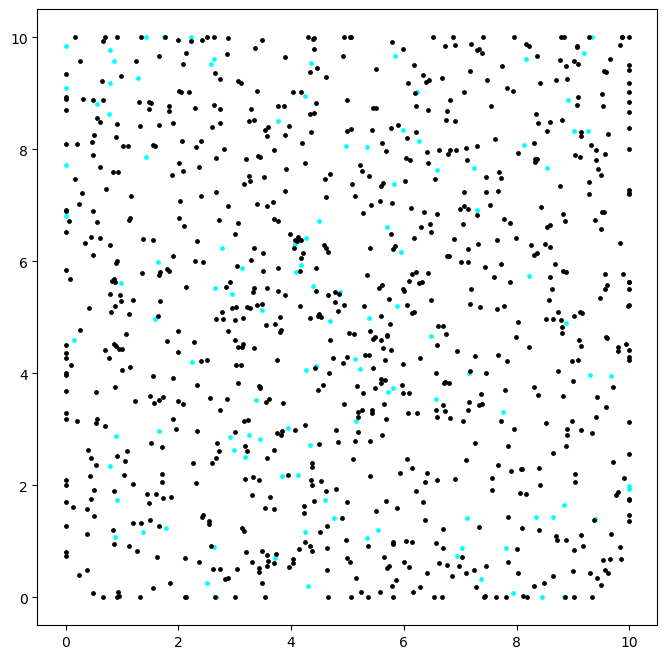

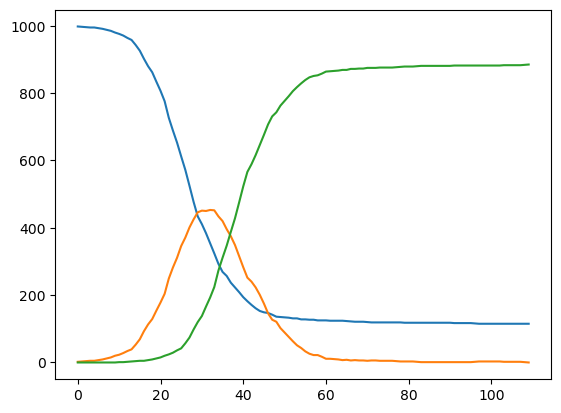

In [5]:
# Baseline variables

v = 0.5    # Drift velocity

G = Population(P, L, r, p, T)
G.start_infection()
G.show_pos()
sus, inf, rem = G.baseline_exp_show(v)

plt.figure()
plt.plot(sus)
plt.plot(inf)
plt.plot(rem)
plt.show()

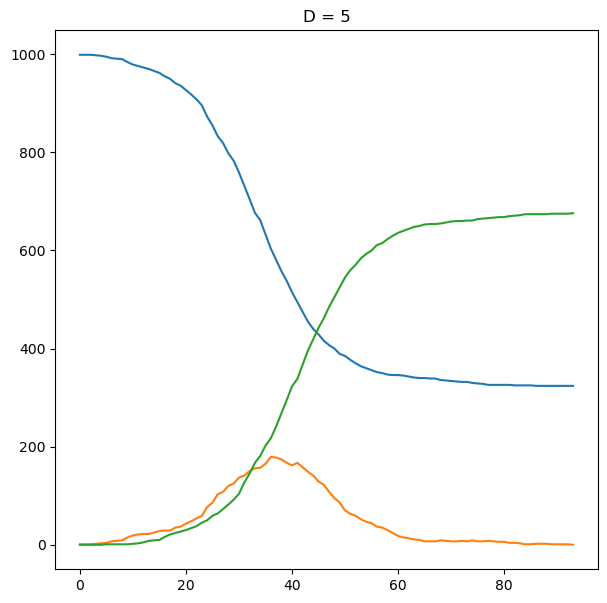

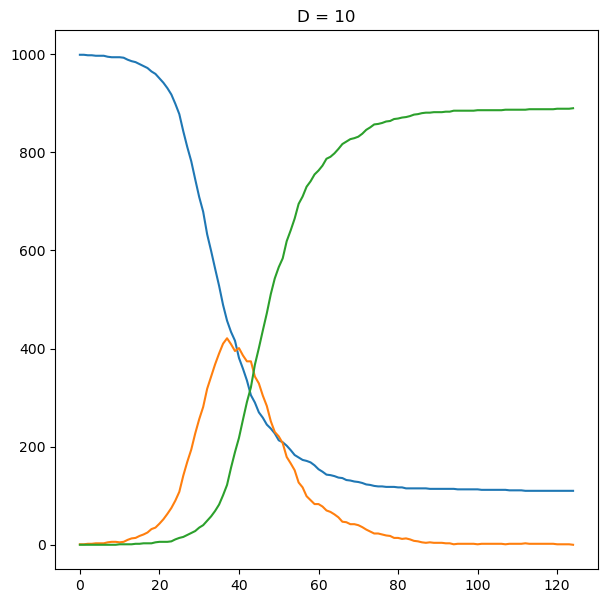

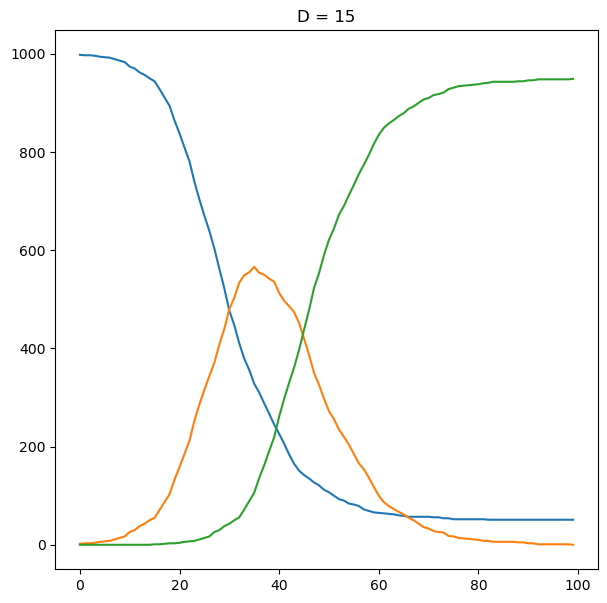

In [6]:
# Baseline variables : effect of p

v = 0.5    # Drift velocity
r = 0.1
p = 0.1

for D in [5, 10, 15]:

    plt.figure(figsize = (7,7))
    G = Population(P, L, r, p, T)
    G.start_infection()
    sus, inf, rem = G.baseline_exp(v)
    plt.title(f'D = {D}')
    plt.show()
    

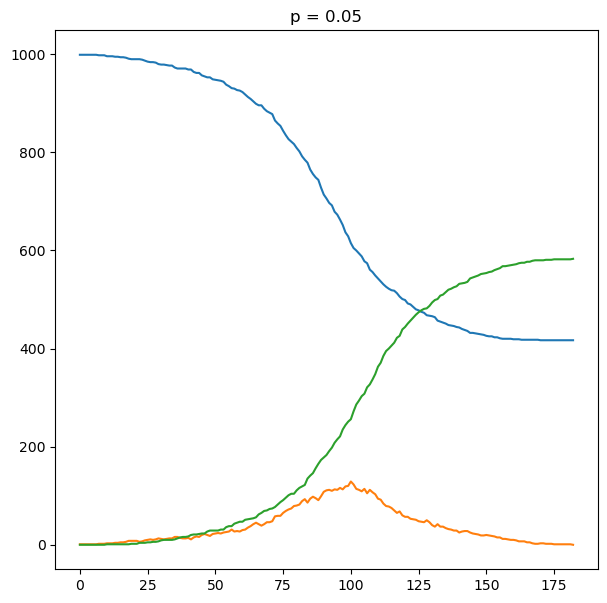

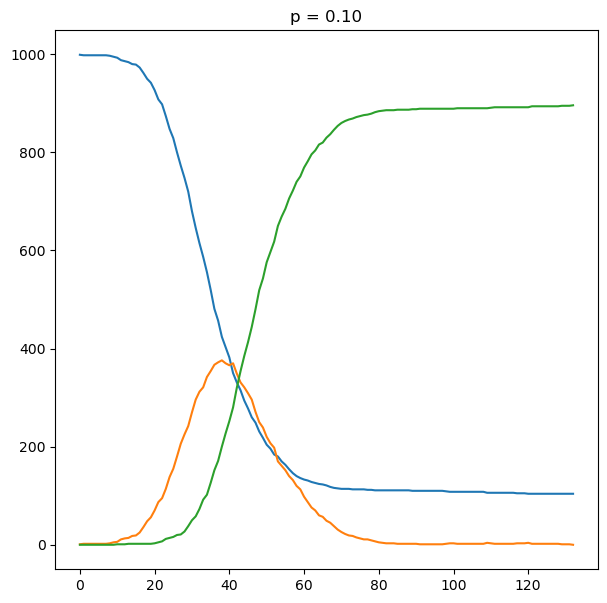

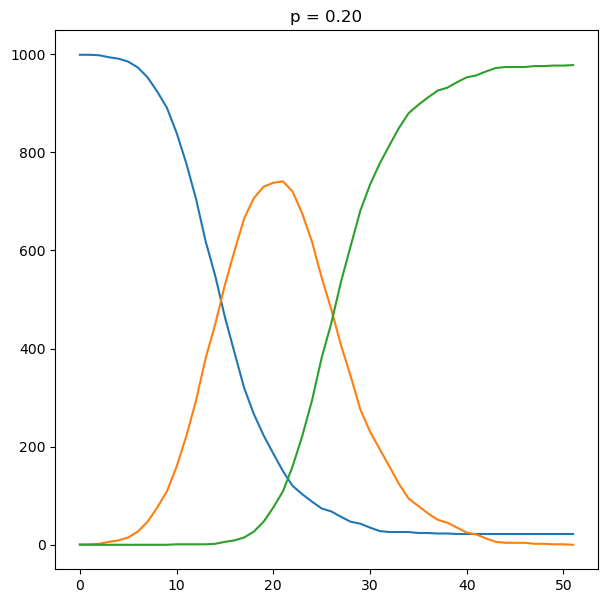

In [7]:
# Baseline variables : effect of p

v = 0.5    # Drift velocity
r = 0.1
D = 10

for p in [0.05, 0.1, 0.2]:

    plt.figure(figsize = (7,7))
    G = Population(P, L, r, p, T)
    G.start_infection()
    sus, inf, rem = G.baseline_exp(v)
    plt.title('p = %1.2f' %p)
    plt.show()
    

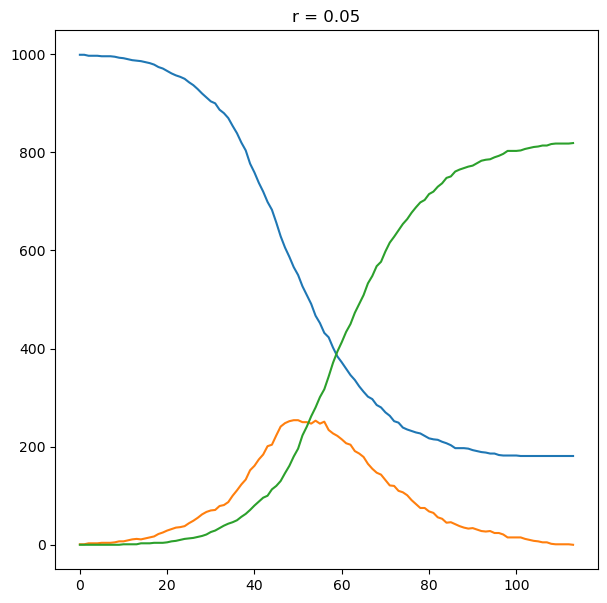

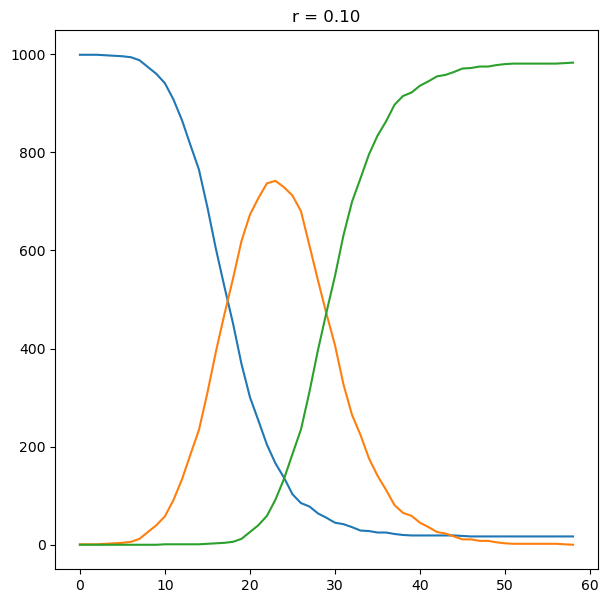

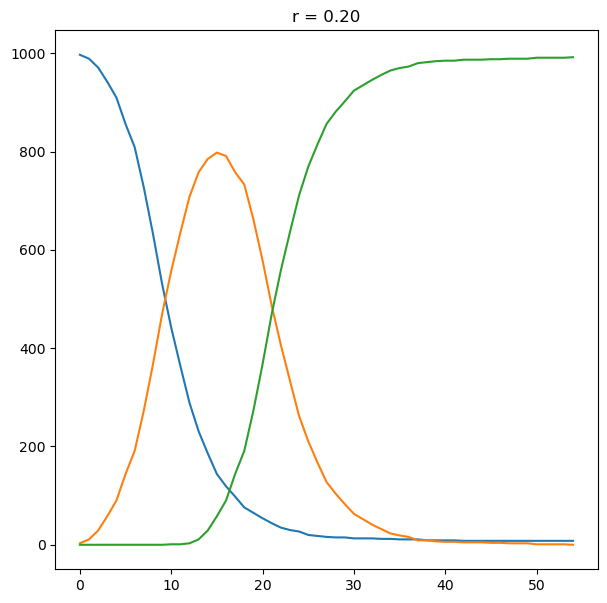

In [8]:
# Baseline variables : effect of r

v = 0.5    # Drift velocity
p = 0.2
D = 10

for r in [0.05, 0.1, 0.2]:

    plt.figure(figsize = (7,7))
    G = Population(P, L, r, p, T)
    G.start_infection()
    sus, inf, rem = G.baseline_exp(v)
    plt.title('r = %1.2f' %r)
    plt.show()
    